# Evaluate group snapshots

In the last notebook, I showed how to prepare group snapshots using `patientflow`. Now, let's think about how to evaluate those models. The goal is to evaluate how well a predicted bed count distribution compares with the observed bed counts over the period of the test set. 

There are various approaches. A common approach is to generate a single number such as mean squared error. For this:

a. for each prediction moment, compare the observed number of admissions and the expected value from the probability distribution for the model predictions at that moment. These can be compared, over the whole test set, using Mean Absolute Error (MAE) - which avoids positive and negative deviations cancelling each other out - and the error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE).  

b. for each prediction moment, compare the expected value of the probability distribution with a rolling average of six weeks

Other methods appraise the performance of the model across the whole distribution. If a model predicts the tails of a distribution well, the observed number of beds would appear in the lowest tenth of the distribution on 10% of prediction moments, and likewise in the highest tenth on 10% of prediction moments. This is evaluated by:

c. a QQ plot, a tool used to compare one probility distribution with another. The observed values across the test set are treated as a distribution, and compared with predicted distribution

### About the data used in this notebook

I'm going to use real patient data from visits to the Emergency Department (ED) and Same Day Emergency Care (SDEC) unit at UCLH to demonstrate the evaluation. The methods shown will work on any data in the same structure. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.




## Loading real patient data

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
import pandas as pd
from patientflow.load import set_file_paths, load_data

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date


Inferred project root: /Users/zellaking/Repos/patientflow


The dates for training, validation and test sets that match this dataset are defined in the config file in the root directory of `patientflow`.

In [4]:
#  
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set = params["start_training_set"]
print(f"Training set starts: {start_training_set}")

start_validation_set = params["start_validation_set"]
print(f"Validation set starts: {start_validation_set}")

start_test_set = params["start_test_set"] 
print(f"Test set starts: {start_test_set}")

end_test_set = params["end_test_set"]
print(f"Test set ends: {end_test_set}")


Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


## Train one model for each prediction time

First, we apply the temporal splits as shown in the previous notebook. 

In [27]:


from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Split sizes: [53801, 6519, 19494]


Next we train a model for each prediction time.

In [6]:
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 

print("\nNumber of observations for each prediction time")
print(ed_visits.prediction_time.value_counts())


Number of observations for each prediction time
prediction_time
(15, 30)    22279
(12, 0)     19075
(22, 0)     18842
(9, 30)     11421
(6, 0)       8197
Name: count, dtype: int64


As shown in the previous notebook, we define ordinal mappings where appropriate. These include:

* `age_group` - Age on arrival at the ED, defined in groups
* `latest_obs_manchester_triage_acuity` - Manchester Triage Score (where blue is the lowest acuity and red the highest)
* `latest_obs_objective_pain_score` - ranging from nil to very severe 
* `latest_obs_level_of_consciousness` the ACVPU measure of consciousness, where A (aware) and U (unconscious) at are the extremes. 

In [7]:
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }


In the real data, there are some columns that will be used for predicting admission to specialty, if admitted, that we don't use here. 

In [8]:
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

We loop through each prediction time, training a model, using balanced training set and re-calibration on the validation set. 

In [25]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

# create a dictionary to store the trained models
trained_models = {}  

# Loop through each prediction time
for prediction_time in prediction_times:
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits,
        valid_visits=valid_visits,
        test_visits=test_visits,
        grid={"n_estimators": [20, 30, 40]},
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_name = 'admissions'
    model_key = get_model_key(model_name, prediction_time)
    
    trained_models[model_key] = model

Training model for (6, 0)
Training model for (9, 30)
Training model for (12, 0)
Training model for (15, 30)
Training model for (22, 0)


## Prepare group snapshots

In [33]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    X_test, y_test = prepare_patient_snapshots(
        df=test_visits, 
        prediction_time=_prediction_time, 
        single_snapshot_per_visit=False,
        exclude_columns=exclude_from_training_data, 
        visit_col='visit_number'
    )

    group_snapshots_dict = prepare_group_snapshot_dict(
        test_visits[test_visits.prediction_time == _prediction_time]
        )
    # get probability distribution for this time of day
    prob_dist_dict_all[model_key] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, trained_models[model_key]
        )


Processing :(6, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(9, 30)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(12, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot

## Evaluate group snapshots

## Comparing observed with expected values

In [37]:
from patientflow.evaluate import calc_mae_mpe
results = calc_mae_mpe(prob_dist_dict_all)
# Print results for verification
for _prediction_time, values in results.items():
    print(f"\n{_prediction_time}:")
    print(f"  MAE: {values['mae']:.2f}")
    print(f"  MPE: {values['mpe']:.2f}%")


admissions_0600:
  MAE: 1.48
  MPE: 41.19%

admissions_0930:
  MAE: 1.32
  MPE: 30.89%

admissions_1200:
  MAE: 2.00
  MPE: 37.48%

admissions_1530:
  MAE: 2.46
  MPE: 26.91%

admissions_2200:
  MAE: 3.17
  MPE: 28.65%


Above, the 09:30 time slot showed the lowest Mean Absolute Error (MAE) at 1.32, indicating it had the most accurate predictions. However, the Mean Percentage Error (MPE) was lowest for the 15:30 time slot at 26.91%, suggesting that while the 15:30 predictions had larger absolute errors, they were proportionally more accurate relative to the actual values. 

The evening admissions (22:00) showed the highest MAE at 3.17, indicating the largest prediction errors occurred during this time period.

Similar observations can be drawn from plotting the observed values against the expected, as shown below.

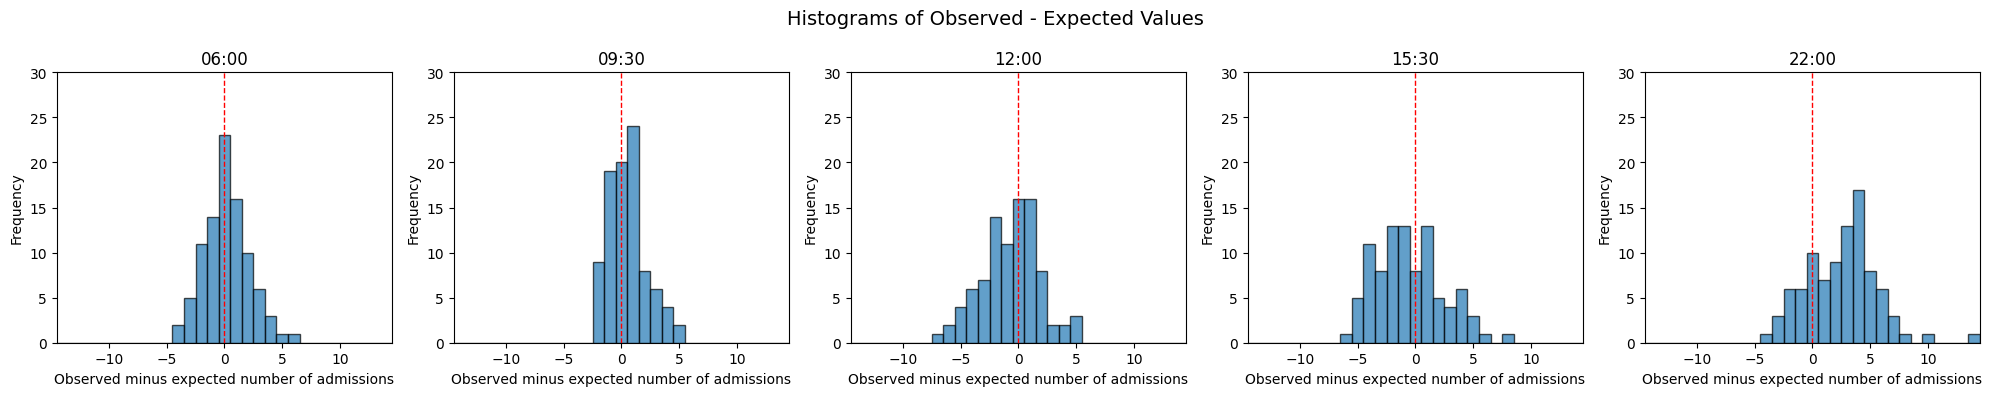

In [38]:
from patientflow.viz.evaluation_plots import plot_observed_against_expected
plot_observed_against_expected(results)

Fro the plots above: 
* The 06:00 data shows a slight positive bias, with most error values indicating that actual admissions were typically higher than predicted.
* The 09:30 data has a similar positive skew but with errors more tightly clustered around 1, confirming its lower MAE.
* The 12:00 distribution appears more spread out with a wider range of errors.
* The 15:30 time slot shows the most balanced distribution around zero, which aligns with its lower MPE.
* The 22:00 time slot displays a distinct positive skew, with most values above zero, suggesting consistent under-prediction (observed values higher than expected).

### QQ (quantile-quantile) Plots

A QQ plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients who were later admitted in each of those snapshot dates. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 

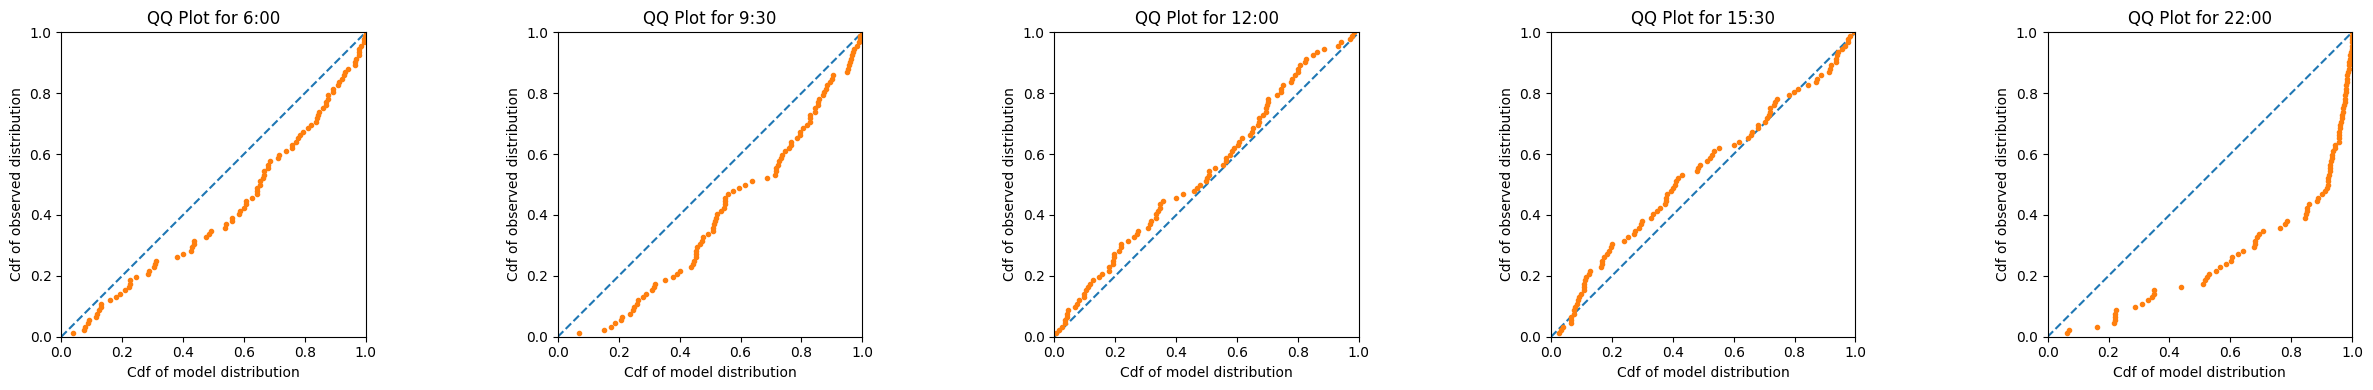

In [36]:
from patientflow.viz.qq_plot import qq_plot

qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions")

The 12:00 distributions show the closest adherence to the theoretical distribution (closest to the diagonal line). The 15:30 plot shows reasonable alignment but with some deviation at the extremes. 
The 06:00 show deviations in the middle range, suggesting some bias in predictions.
The 09:30 plot shows some deviation at the lower end. 
The 22:00 QQ plot shows significant deviation from the theoretical distribution, with a particularly strong departure in the upper quantiles.

## Conclusions

Here I have demonstrated some methods for evaluating predicted distributions. 

We prefer the QQ plot for evaluating probability distribution predictions for several reasons.

QQ plots directly compare the entire predicted and observed distributions, revealing systematic deviations across the full probability range. Unlike summary statistics like MAE or MPE that reduce complex distributional information to single values, QQ plots preserve and visualize the whole distribution. This comprehensive view is particularly valuable for detecting issues in the tails of distributions, where rare but consequential events occur. For instance, in the 22:00 time slot from your data, the QQ plot reveals significant deviations in the upper quantiles that summary statistics might obscure.

QQ plots are good for identifying specific types of mismatches — for example whether a model systematically under-predicts high values, over-predicts low values, or misses multimodality in the data. These insights can inform model improvement by showing where and how the predicted distribution fails.

QQ plots maintain their interpretability regardless of scale differences between distributions.